# Earth - Geoid height grid at 10 arc-minute resolution

Global 10 arc-minute resolution grids of geoid height with respect to the WGS84 ellipsoid.

**Source:** [EIGEN-6C4](https://doi.org/10.5880/icgem.2015.1) spherical harmonic model (generated by the [ICGEM calculation service](http://icgem.gfz-potsdam.de/home))

**License:** [CC-BY](https://doi.org/10.5880/icgem.2015.1)

## Notes

This notebook loads the grid from the text file, sets proper CF-compliant metadata, and saves it to compressed netCDF for a smaller file size (requires the netcdf4 library for loading). Coordinates are referenced to WGS84.

In [1]:
import os
import lzma
from pathlib import Path
import xarray as xr
import numpy as np
import harmonica as hm
import pygmt
import pooch

## Read the data

Use pandas to read the data.

In [2]:
with lzma.open(Path("raw") / "EIGEN-6C4_geoid.gdf.xz", "rt") as f:
    data = hm.load_icgem_gdf(f, dtype="float32")
icgem_metadata = data.attrs.copy()
data = data.geoid
data

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.497599, -29.497599, -29.497599, ..., -29.497599, -29.497599,
        -29.497599],
       [-29.548712, -29.548435, -29.548159, ..., -29.549261, -29.548986,
        -29.548712],
       [-29.64522 , -29.644733, -29.644245, ..., -29.646185, -29.645702,
        -29.64522 ],
       ...,
       [ 14.706275,  14.7046  ,  14.70293 , ...,  14.709636,  14.707953,
         14.706275],
       [ 15.203397,  15.202868,  15.202341, ...,  15.204455,  15.203925,
         15.203397],
       [ 15.423886,  15.423886,  15.423886, ...,  15.423886,  15.423886,
         15.423886]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float32 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0

## Fix grid coordinates

Coordinates are slightly imprecise since ICGEM uses something like `np.arange` to generate them instead of `np.linspace`, which is more precise and the correct way to do it. This means that the spacing is not exactly constant, which can mess up plotting with PyGMT later on. Fix this by assigning adjusted coordinates. This shouldn't make a difference quantitatively since changes are in the order of 1e-5 or below.

In [3]:
def fix_coordinates(grid):
    """
    Replace coordinates with ones generated with np.linspace.
    """
    longitude = np.linspace(-180, 180, grid.longitude.size)
    latitude = np.linspace(-90, 90, grid.latitude.size)
    return grid.assign_coords(longitude=longitude, latitude=latitude)

In [4]:
data = fix_coordinates(data)
data

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.497599, -29.497599, -29.497599, ..., -29.497599, -29.497599,
        -29.497599],
       [-29.548712, -29.548435, -29.548159, ..., -29.549261, -29.548986,
        -29.548712],
       [-29.64522 , -29.644733, -29.644245, ..., -29.646185, -29.645702,
        -29.64522 ],
       ...,
       [ 14.706275,  14.7046  ,  14.70293 , ...,  14.709636,  14.707953,
         14.706275],
       [ 15.203397,  15.202868,  15.202341, ...,  15.204455,  15.203925,
         15.203397],
       [ 15.423886,  15.423886,  15.423886, ...,  15.423886,  15.423886,
         15.423886]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0

## Set proper metadata

Add proper metadata following CF-conventions to all `DataArrays` and the `Dataset` as a whole.

In [5]:
def minmax_round(grid, decimals):
    """
    Return the minimum and maximum values in the grid 
    rounded to *decimal* places.
    """
    vmin = np.round(grid.values.min(), decimals=decimals)
    vmax = np.round(grid.values.max(), decimals=decimals)
    return (vmin, vmax)

In [6]:
data.attrs = {
    "Conventions": "CF-1.8",
    "title": "Geoid height (EIGEN-6C4) with respect to WGS84",
    "crs": "WGS84",
    "source": "Generated from the EIGEN-6C4 model by the ICGEM Calculation Service (http://icgem.gfz-potsdam.de)",
    "license": "Creative Commons Attribution 4.0 International Licence",
    "references": "https://doi.org/10.5880/icgem.2015.1",
    "long_name": "geoid height",
    "standard_name": "geoid_height_above_reference_ellipsoid",
    "description": "height of the geoid with respect to the WGS84 ellipsoid",
    "units": "m",
    "actual_range": minmax_round(data, decimals=1),
    "icgem_metadata": "\n".join([f"{k}: {v}" for k,v in icgem_metadata.items()]),
}
data.longitude.attrs = {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degrees_east",
    "actual_range": (data.longitude.values.min(), data.longitude.values.max()),
}
data.latitude.attrs = {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degrees_north",
    "actual_range": (data.latitude.values.min(), data.latitude.values.max()),
}
data

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.497599, -29.497599, -29.497599, ..., -29.497599, -29.497599,
        -29.497599],
       [-29.548712, -29.548435, -29.548159, ..., -29.549261, -29.548986,
        -29.548712],
       [-29.64522 , -29.644733, -29.644245, ..., -29.646185, -29.645702,
        -29.64522 ],
       ...,
       [ 14.706275,  14.7046  ,  14.70293 , ...,  14.709636,  14.707953,
         14.706275],
       [ 15.203397,  15.202868,  15.202341, ...,  15.204455,  15.203925,
         15.203397],
       [ 15.423886,  15.423886,  15.423886, ...,  15.423886,  15.423886,
         15.423886]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    (-106.5, 86.0)
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


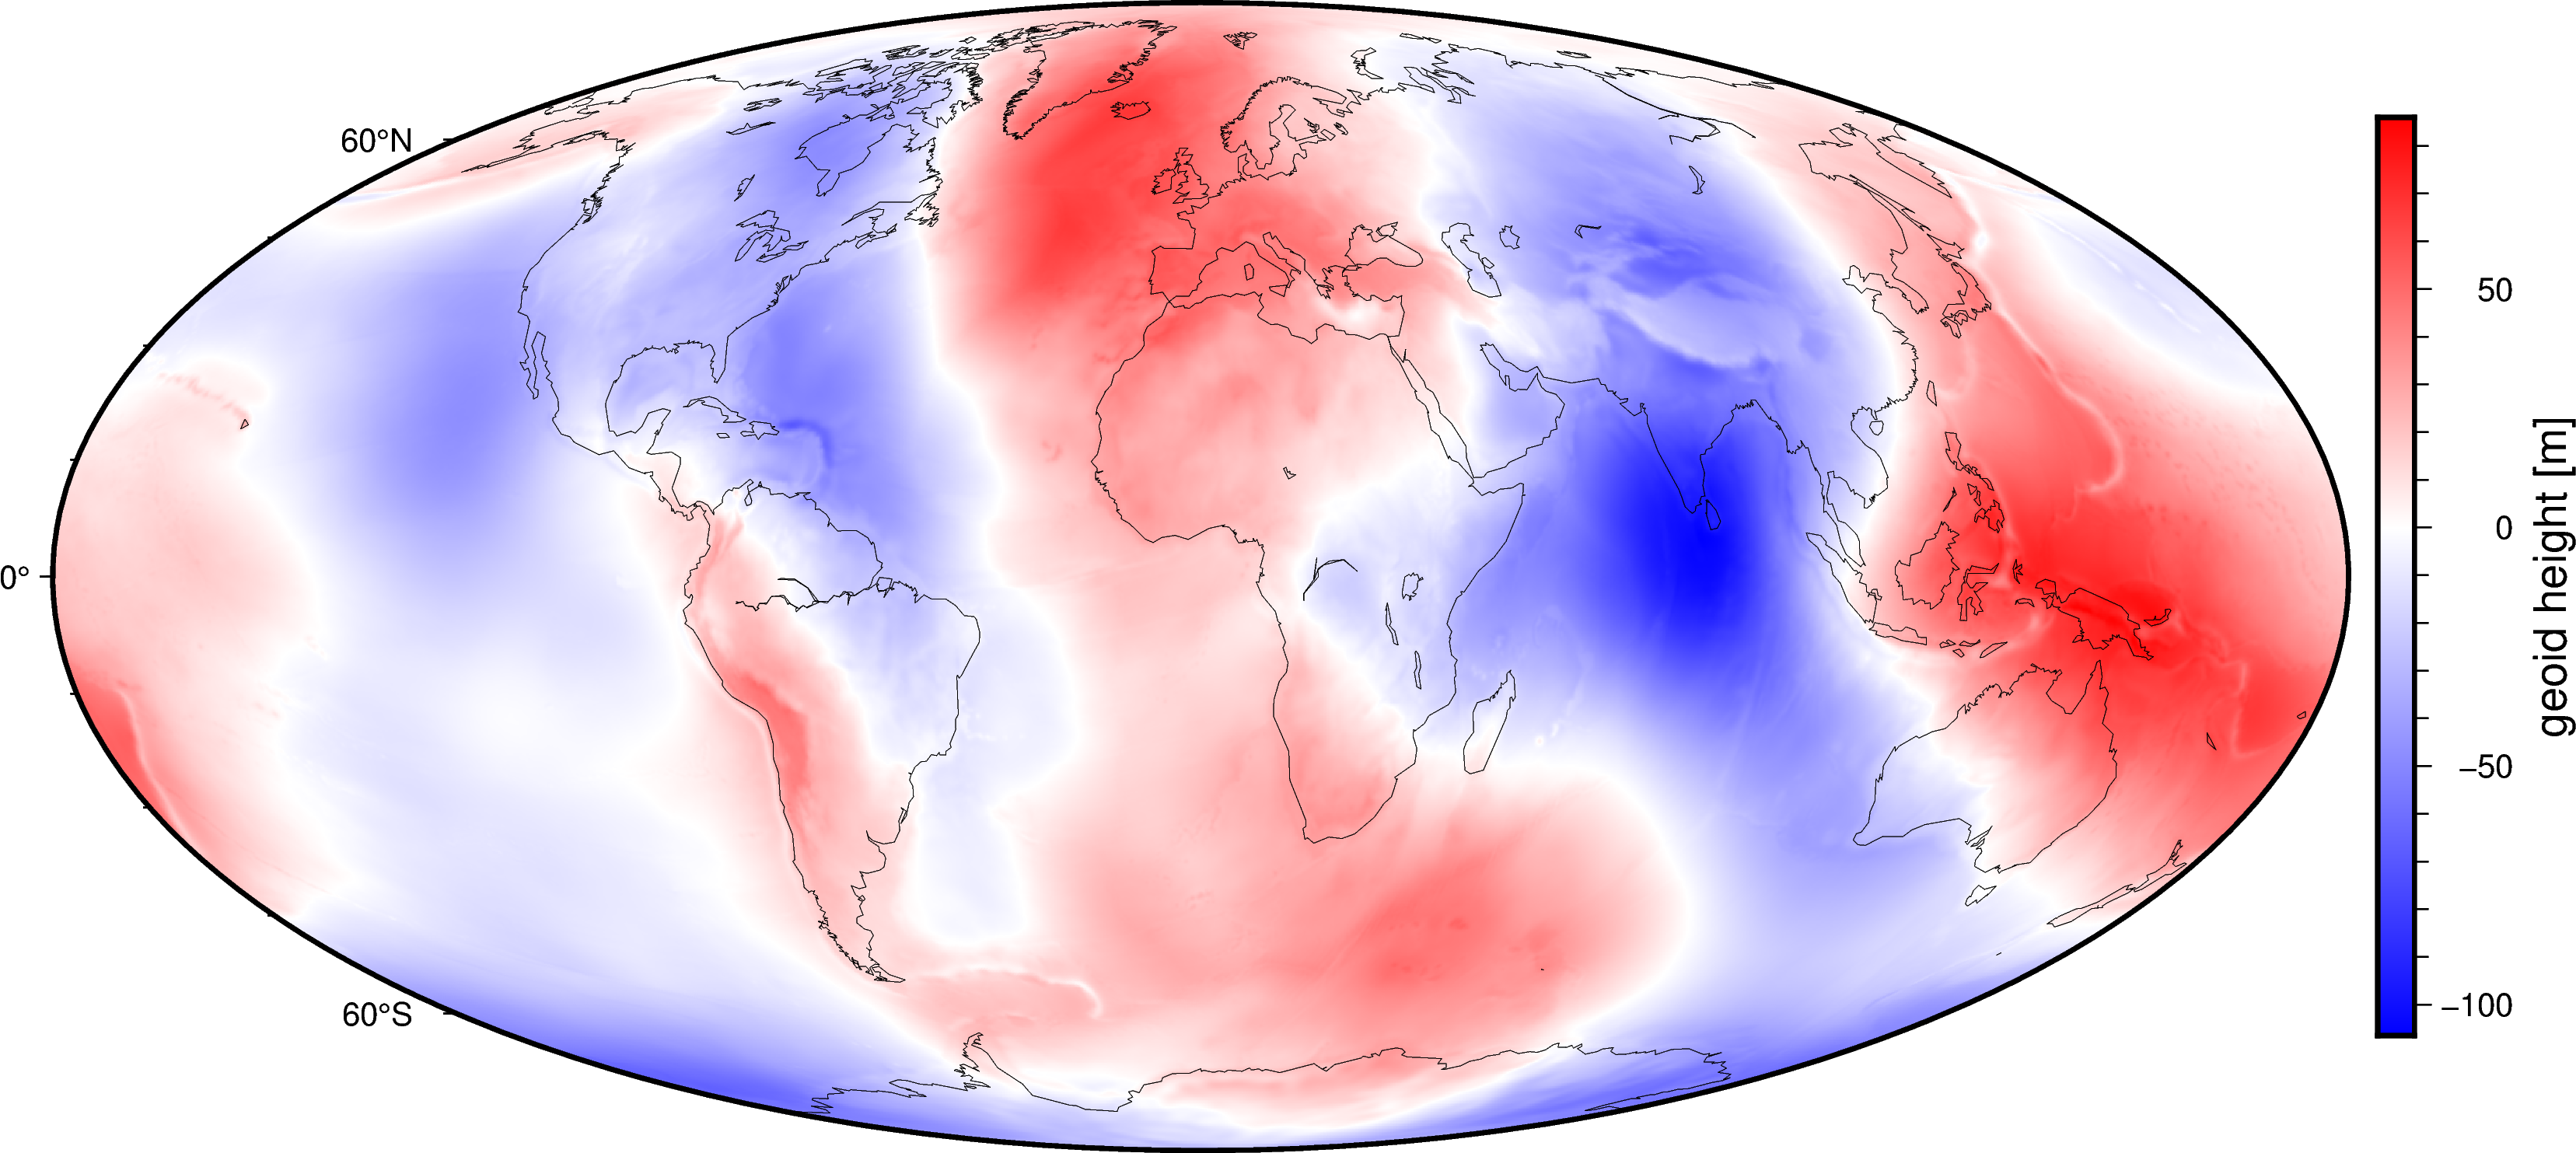

In [7]:
fig = pygmt.Figure()
fig.grdimage(data, cmap="polar+h", projection="W25c")
fig.colorbar(frame='af+l"geoid height [m]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p", area_thresh=1e4)
fig.savefig("preview.jpg", dpi=200)
fig.show()

## Export

Save the grid to a netCDF file and calculate the size and MD5/SHA256 hashes. 

Use compression (both zlib and discretization based) to reduce the file sizes. The `scale_factor` determines the amount of decimal places retained when converting floats into integers. See http://xarray.pydata.org/en/stable/user-guide/io.html#writing-encoded-data

In [8]:
output = "earth-geoid-10arcmin.nc"
data.to_netcdf(
    output, 
    format="NETCDF4",
    encoding={
        'geoid': {
            "zlib": True, 
            'dtype': 'int16', 
            'scale_factor': 0.1, 
            '_FillValue': 32000, 
            'add_offset': 0,
        },
    }
)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: earth-geoid-10arcmin.nc
size: 1.340412 Mb
md5:39b97344e704eb68fa381df2eb47da0f
sha256:e98dd544c8b4b8e5f11d1a316684dfbc2612e2860af07b946df46ed9f782a0f6


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [9]:
data_reloaded = xr.load_dataarray(output)
data_reloaded

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.6     , -29.6     , -29.6     , ..., -29.6     , -29.6     ,
        -29.6     ],
       ...,
       [ 14.7     ,  14.7     ,  14.7     , ...,  14.7     ,  14.7     ,
         14.7     ],
       [ 15.2     ,  15.2     ,  15.2     , ...,  15.2     ,  15.2     ,
         15.2     ],
       [ 15.400001,  15.400001,  15.400001, ...,  15.400001,  15.400001,
         15.400001]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    [-106.5   86. ]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

Make the figure again but don't save it to a file this time.

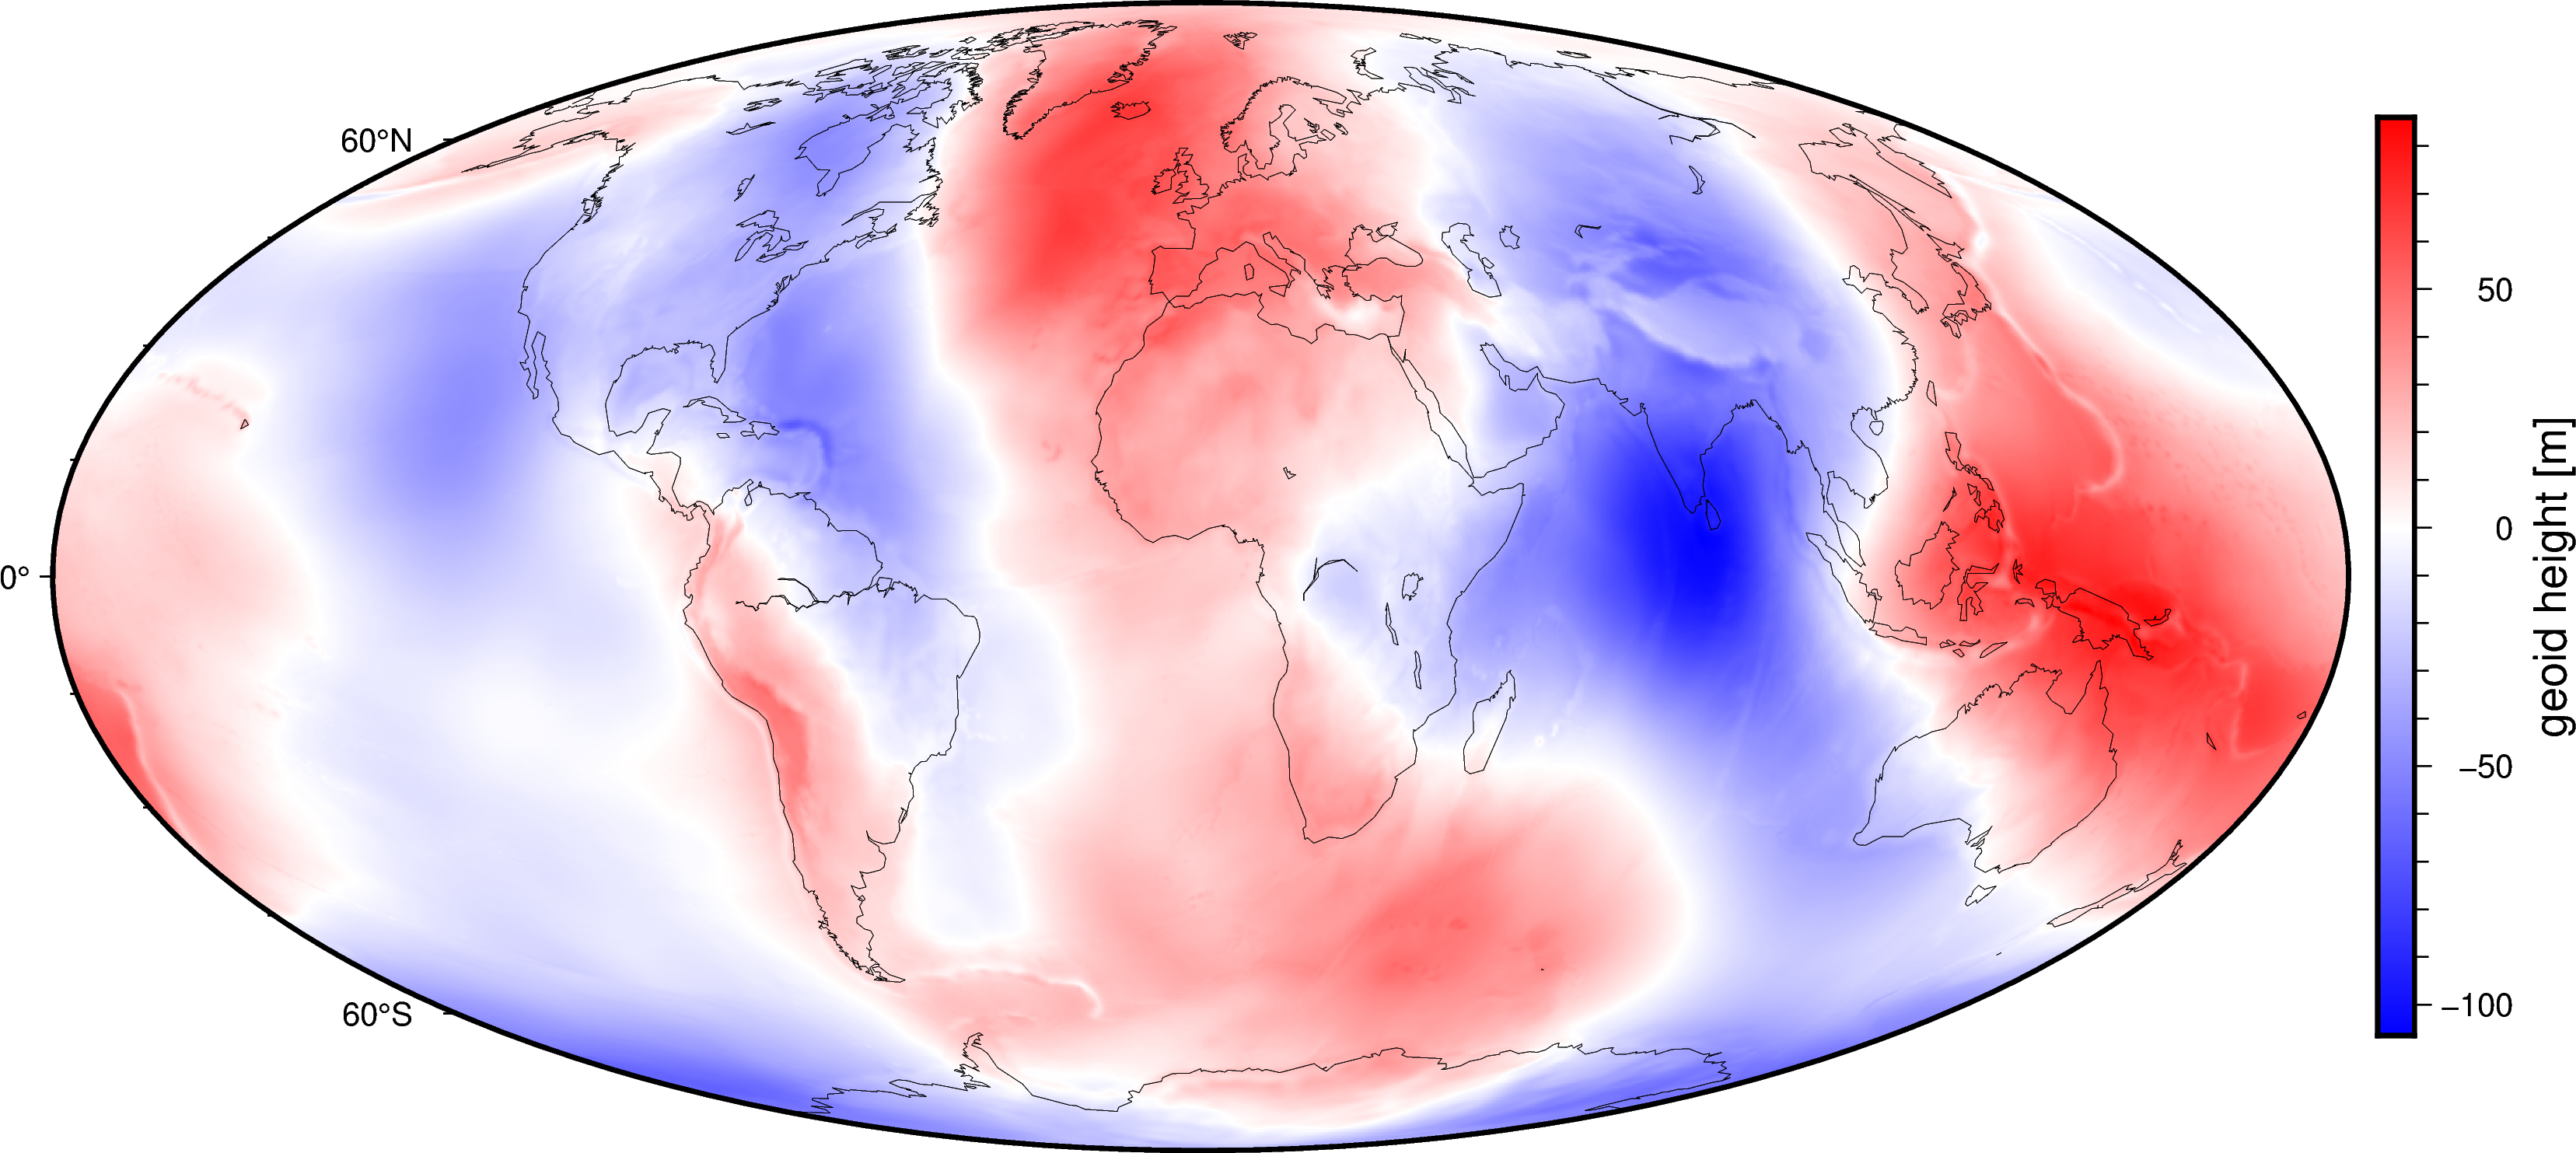

In [10]:
fig = pygmt.Figure()
fig.grdimage(data_reloaded, cmap="polar+h", projection="W25c")
fig.colorbar(frame='af+l"geoid height [m]"', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p", area_thresh=1e4)
fig.show()